## TensorFlow_functional API

In [ ]:
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D 


mnist = tf.keras.datasets.mnist   

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()  

train_images = train_images / 255.0 
test_images = test_images / 255.0  



def model() : 

    input_layer = Input(shape = (28, 28))    

     
    flaten        = Flatten()(input_layer) 
    dense_1       = Dense(128, activation='relu')(flaten) 
    dense_2       = Dense(54, activation='relu')(dense_1) 
    output_layer  = Dense(10, activation='softmax')(dense_2)   

    model = Model(inputs = input_layer, outputs = output_layer) 
    return model 



model = model() 

model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) 


model.fit(train_images, train_labels, epochs = 5) 

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4405 - accuracy: 0.8725
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1042 - accuracy: 0.9687
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0683 - accuracy: 0.9794
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0511 - accuracy: 0.9841
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0391 - accuracy: 0.9871


## Build a Multi-output Model
In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the UCI Machine Learning Repository. It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

We define a few utilities for data conversion and visualization to make our code more neat.

In [ ]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

We download the dataset and format it for training.

In [ ]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. [y1_output, y2_output]) when we instantiate the Model() class.

In [ ]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

#from tensorflow.keras.layers import Layer

#model._layers = [
#                 layer for layer in model._layers if isinstance(layer, Layer)   # if use later version tf
#] 

#plot_model(model)
#plot_model(model, show_shapes=True, show_layer_names=True, to_file = 'model.png')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

We specify the optimizer as well as the loss and metrics for each output.

In [ ]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.Accuracy(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})


In [ ]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 11ms/step - loss: 635.6110 - y1_output_loss: 296.6293 - y2_output_loss: 338.9817 - y1_output_accuracy: 0.0000e+00 - y2_output_root_mean_squared_error: 17.6446 - val_loss: 47.1262 - val_y1_output_loss: 17.4994 - val_y2_output_loss: 29.6268 - val_y1_output_accuracy: 0.0000e+00 - val_y2_output_root_mean_squared_error: 5.4430
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 33.6828 - y1_output_loss: 13.1287 - y2_output_loss: 20.5540 - y1_output_accuracy: 0.0000e+00 - y2_output_root_mean_squared_error: 4.5170 - val_loss: 21.9183 - val_y1_output_loss: 10.6688 - val_y2_output_loss: 11.2495 - val_y1_output_accuracy: 0.0000e+00 - val_y2_output_root_mean_squared_error: 3.3540
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 25.2917 - y1_output_loss: 10.6554 - y2_output_loss: 14.6363 - y1_output_accuracy: 0.0000e+00 - y2_output_root_mean_squared_error: 3.7787 - val_loss: 24.2554 - val_y1_output

In [ ]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y) # normalization
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))


5/5 [==============================] - 0s 2ms/step - loss: 0.9021 - y1_output_loss: 0.2390 - y2_output_loss: 0.6631 - y1_output_accuracy: 0.0000e+00 - y2_output_root_mean_squared_error: 0.8143
Loss = 0.9020507335662842, Y1_loss = 0.23896852135658264, Y1_mse = 0.0, Y2_loss = 0.6630821824073792, Y2_mse = 0.8142985701560974


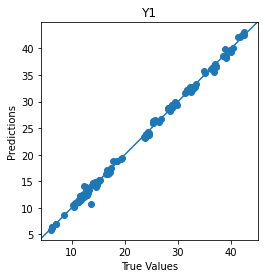

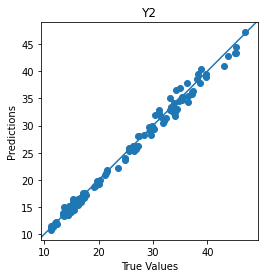

KeyError: ignored

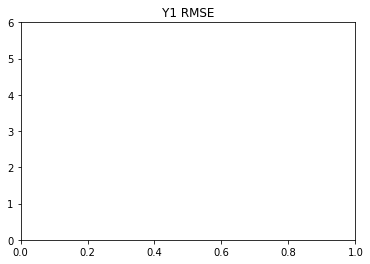

In [ ]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)


In [ ]:
# example


import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Flatten, Dense , Input  

input_layer = Input( shape = (None, None)) 

layer_1 = Dense(64, activation= 'relu', name ='deses_1')(input_layer) 
layer_2 = Dense(32, activation= tf.nn.tanh(), name = 'dense_2')(layer_1) 


y_1_output = Dense(1, activation=tf.nn.sigmoid())(layer_2)


layer_3 = Dense( 128, activation= tf.nn.relu())(layer_2) 

y_2_output = Dense(1, activation=tf.nn.sigmoid())(layer_3)

# we can use merge = Concatenate([layer1, layer2, layer3,..])

model = Model(inputs = input_layer, outputs = [y_1_output, y_2_output]) 

# we can also use Model(inputs = [input1, input2], outputs = [output1, output2]) 

# compile the model 

model.compile(optimizer = tf.keras.optimizers.Adam(), 
                loss = { 'y_1_output' : 'mse', 
                          'y_2_output': "mae" 
                        }, 
                metircs = { 'y_1_output' : tf.keras.metrics.RootMeanSquaredError() ,
                            'y_2_output' : tf.keras.metircs.RootMeanSquaredError() 
                         }
                )    


In [ ]:
input_layer = Input(shape(len(train.columns),))              
first_dense = Dense(128, activation = 'relu')(input_layer)
second_dense = Dense(128, activation = 'relu')(input_layer)



## Intro Siamese Network

Metric Learning as a measure of Similarity

### Ungraded Lab: Implement a Siamese network

This lab will go through creating and training a multi-input model. You will build a basic Siamese Network to find the similarity or dissimilarity between items of clothing. For Week 1, you will just focus on constructing the network. You will revisit this lab in Week 2 when we talk about custom loss functions.

In [ ]:
#Imports
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [ ]:
#First define a few utilities for preparing and visualizing your dataset.
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):  # create pairs on train and test sets
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [ ]:
# You can now download and prepare our train and test sets. You will also create pairs of images that will go into the multi-input model.
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4423680/4422102 [==============================] - 0s 0us/step


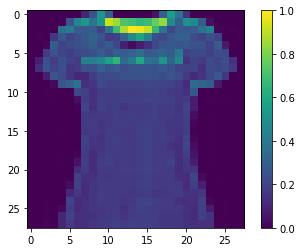

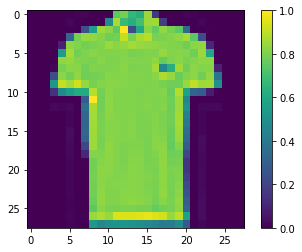

1.0


In [ ]:
# You can see a sample pair of images below.

# array index
this_pair = 8

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(tr_y[this_pair])

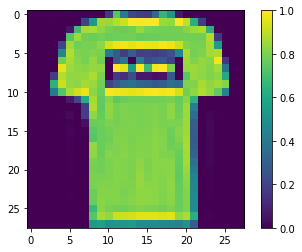

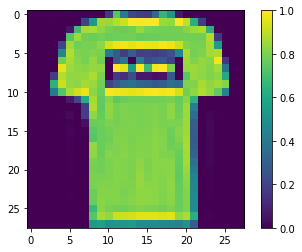

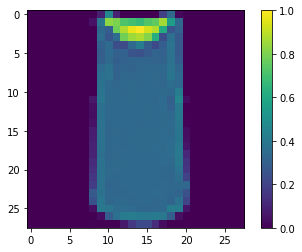

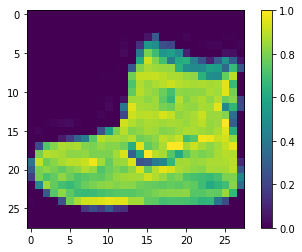

In [ ]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

In [ ]:
# Next, you'll define some utilities for building our model.

def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

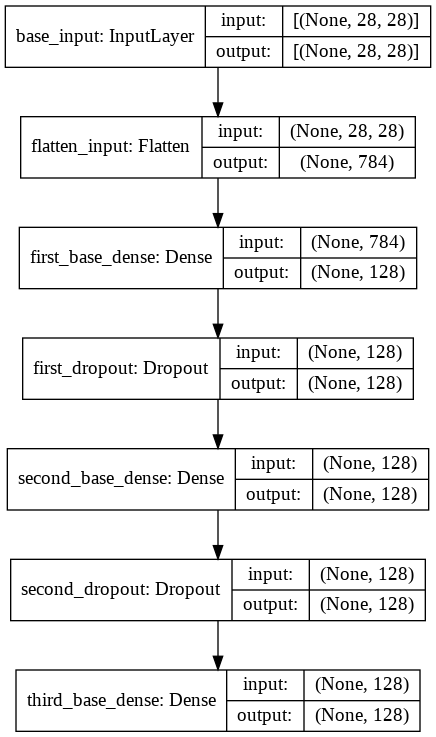

In [ ]:
#Let's see how our base network looks. This is where the two inputs will pass through to generate an output vector.
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

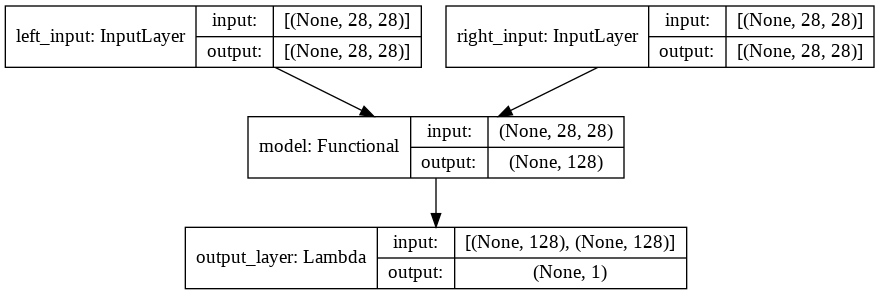

In [ ]:
# Let's now build the Siamese network. The plot will show two inputs going to the base network.

# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

Contrastive loss function

`Y * square(D) + (1-Y) * square(max(margin-D, 0))`

Y is tensor of details about image similarities, 1 for similar or 0 for dissimilar  `y_true`

D is the Euclidean distances between the pairs of images `y_pred`

margin is constant, to enforce the mini distance between in order to find the simi or dissimi

In [ ]:
# You can now define the custom loss for our network and start training. Don't worry about why it's written as a nested function just yet. You will revisit this in Week 2.
def contrastive_loss_with_margin(margin):  # margin = 1 is default
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [ ]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

In [ ]:
# As usual, you can evaluate our model by computing the accuracy and observing the metrics during training.
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

In [ ]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

NameError: ignored

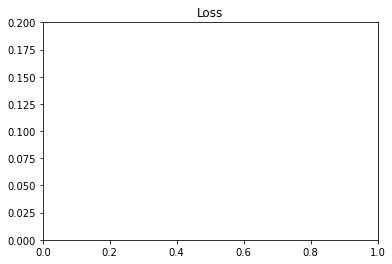

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [ ]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

In [ ]:
# You can see sample results for 10 pairs of items below.
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)

In [ ]:
# don't run code 

import tensorflow as tf 
from tensorflow.keras.layers import Dense, Flatten, Lambda  , Input 
from tensorflow.keras.models import Model 
from tensorflow.keras import backend as K 
from tensorflow.keras.utils import plot_model 

def base_model() : 

    inputs = Input(shape = (28, 28), name = 'input_layer') 
    x = Flatten(name = 'Flatten_layer')(inputs) 
    x = Dense(64, activation= 'relu')(x) 
    x = Dense(32, activation= 'relu')(x) 

    return Model(inputs = inputs, outputs = x) 


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1) 


# initialize the base network   

base_network = base_model()  

# create the left input and point to the base network

input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network

input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs 
# lambda layer gives flexibility for custom layers

output = Lambda(euclidean_distance, name="output_layer", 
                output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output) 

plot_model(model, to_file = 'siamese.png', show_shapes= True, show_layer_names=True) 


#loss for siamese network 
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

## custom_losses

###Ungraded Lab: Huber Loss

In this lab, we'll walk through how to create custom loss functions. In particular, we'll code the Huber Loss and use that in training the model.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
from tensorflow import keras

Prepare the Data

Our dummy dataset is just a pair of arrays xs and ys defined by the relationship `𝑦=2𝑥−1`. xs are the inputs, while ys are the labels.

In [ ]:
# inputs
xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)

# labels
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

Training the model

Let's build a simple model and train using a built-in loss function like the `mean_squared_error`.

We could use the string `mse`, `mean_squared_error` 

or 
the object from lib, we can add parameter to object `loss = mean_squared_error (parameter)`

```
from tensorflow.keras.losses import mean_squared_error
model.compile(optimizer = 'sgd', loss = mean_squared_error(para=value))
```


In [ ]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(xs, ys, epochs=500,verbose=0)

print(model.predict([10.0]))

Custom Loss

Now let's see how we can use a custom loss. We first define a function that accepts *the ground truth labels* `(y_true)`  and *model predictions* `(y_pred)` as parameters. We then compute and return the loss value in the function definition.

Loss(a) = 1/2 * squere(a) if |a|<= threshold=b

Loss(a) = b*(|a|-1/2*b)  else

b is threshold, a is error (label-prediction)

In [ ]:
def my_huber_loss(y_true, y_pred):
    threshold = 1
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= threshold # Boolean value
    small_error_loss = tf.square(error) / 2
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    return tf.where(is_small_error, small_error_loss, big_error_loss) # three parameters
    # if is_small_error is true, return small_, if is false, return big_

Using the loss function is as simple as specifying the loss function in the loss argument of `model.compile()`.

In [ ]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss=my_huber_loss)
model.fit(xs, ys, epochs=500,verbose=0)
print(model.predict([10.0]))

In [ ]:
# DON'T RUN THIS CODE 

import  tensorflow as tf 
from tensorflow import keras  

# code for custom huber loss 

def my_huber_loss(y_true, y_pred): 

    threshold = 1
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= threshold
    small_error_loss = tf.square(error) / 2
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    return tf.where(is_small_error, small_error_loss, big_error_loss) 


model = tf.keras.models.Sequential([ tf.keras.layers.Dense(20, activation='relu')])

model.compile(optimizer = 'sgd', loss = my_huber_loss) # using custom loss 

## custom_class_loss

The `loss` argument in `model.compile()` only accepts functions that accepts two parameters: the ground truth (`y_true`) and the model predictions (`y_pred`). If we want to include a hyperparameter that we can tune, then we can define a wrapper function that accepts this hyperparameter.

In [ ]:
import tensorflow as tf 
from tensorflow import keras  
from tensorflow.keras.losses import Loss 

# custom loss with hyperparameter 

def my_huber_loss_with_threshold(threshold): 
    
    def my_huber_loss(y_true, y_pred) : 
        error =  y_true - y_pred 
        is_small_error = tf.abs(error) <= threshold 
        small_error_loss = tf.square(error) / 2
        big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
        
        return tf.where(is_small_error, small_error_loss, big_error_loss) 

    # return the inner function tuned by the hyperparameter
    return my_huber_loss 

model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss=my_huber_loss_with_threshold(threshold=1.2)) #calling loss 



# CUSTOM LOSS AS A CLASS 


class MyHuberLoss(Loss) :  # we put parent class Loss to class MyHuberLoss
    
    threshold = 1  # declare threshold as class variable, allow us give an initial value, final value is not the default 1

    def __init__(self, threshold): # this threshold is just parameter, not class variable self.threshold
        super().__init__() 
        self.threshold = threshold # set threshold class variable to be parameterized one

    def call(self, y_true, y_pred) : # self is class parameter, then we use self.threshold
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        return tf.where(is_small_error, small_error_loss, big_error_loss)



model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss=MyHuberLoss(threshold=1.02)) #calling loss 

## lambda_layers

In [ ]:
import tensorflow as tf 
from tensorflow.keras import backend as K # 



model = tf.keras.models.Sequential([ 

    tf.keras.layers.Flatten() ,
    tf.keras.layers.Dense(128) ,# we need to use both Dense and lambda (activation)
    tf.keras.layers.Lambda(lambda x : tf.abs(x)) ,  # we can directly define the lambda function as the absolute value of x
                 # it takes values from previous layer and take absolute values of x 


    tf.keras.layers.Dense(10, activation= 'softmax')
])



#custom relu  function 
def my_relu(x):
    return K.maximum(-0.1, x)  # we can reset the threshold of the relu function with -0.1


model = tf.keras.models.Sequential([ 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128) ,
    tf.keras.layers.Lambda(my_relu) , 
    tf.keras.layers.Dense(10, activation='softmax')

])



## custom_layer

###Ungraded Lab: Building a Custom Dense Layer

In this lab, we'll walk through how to create a custom layer that inherits the Layer class. Unlike simple Lambda layers you did previously, the custom layer here will contain weights that can be updated during training.

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np

Custom Layer with weights

To make custom layer that is trainable, we need to define a class that inherits the Layer base class from Keras. The Python syntax is shown below in the class declaration. This class requires three functions: `__init__()`, `build()` and `call()`. These ensure that our custom layer has a state and computation that can be accessed during training or inference.

In [ ]:
# inherit from this base class
from tensorflow.keras.layers import Layer

class SimpleDense(Layer):

    def __init__(self, units=32):  # accepts the parameters and it sets up the internal variables
        '''Initializes the instance attributes''' # pass the initialization back to the base class
        super(SimpleDense, self).__init__() # super is the layer class, which SimpleDense inherites from
        # just to make sure that your initialization is moving up the inheritance chain.
        self.units = units  # local variable units and default to 32

    def build(self, input_shape): # specify your local input states "w" and "b" as w*X+b

        '''Create the state of the layer (weights)'''
        # initialize the weights
        w_init = tf.random_normal_initializer() # one of the initializers to the input value by normal distribution
        self.w = tf.Variable(name="kernel", # we can trace it later with the name
            initial_value = w_init(shape=(input_shape[-1], self.units), # [-1] is the last value of the input_shape
                                 dtype='float32'),
            trainable=True)
        # this is the tensor--tf.Variable, and self.w holds the state

        # initialize the biases
        b_init = tf.zeros_initializer() # set it to zero with initialization
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.units,), dtype='float32'),
            trainable=True)

    def call(self, inputs): # computation
        '''Defines the computation from inputs to outputs'''
        return tf.matmul(inputs, self.w) + self.b


# declare an instance of the class
my_dense = SimpleDense(units=1)

# define an input and feed into the layer
x = tf.ones((1, 1))
y = my_dense(x)

# parameters of the base Layer class like `variables` can be used
print(my_dense.variables)




### Ungraded Lab: Activation in Custom Layers

To use the built-in activations in Keras, we can specify an `activation` parameter in the `__init__()` method of our custom layer class. From there, we can initialize it by using the `tf.keras.activations.get()` method. This takes in a string identifier that corresponds to one of the [available activations](https://keras.io/api/layers/activations/#available-activations) in Keras. Next, you can now pass in the forward computation to this activation in the `call()` method.

In [ ]:
import tensorflow as tf 
from tensorflow.keras.layers import Layer 


class MyDense(Layer) : 
    
    def __init__(self, units = 32, activation = None) : 
        super().__init__()  
        self.units = units   
        self.activation = tf.keras.activations.get(activation) 

    def build(self, input_shape) : # create the state of the layer weights 
        
        w_init = tf.random_normal_initializer() 

        self.w = tf.Variable(name = 'kernal', 
                    initial_value= w_init(shape = (input_shape[-1], self.units), 
                       dtype= 'float32') , trainable= True)  

        b_init = tf.zeros_initializer() 

        self.b = tf.Variable(name = 'bias', 
                                initial_value= b_init(shape = (self.units,), 
                                 dtype= 'float32'), trainable= True)   
        
        super().build(input_shape) 

    def call(self, inputs) :   # defines the computation from inputs to outputs 
        return self.activation(tf.matmul(inputs, self.w) + self.b) 
        




my_dense = MyDense(units= 1) 

x = tf.ones((1,1)) 
y = my_dense(x) 

print(my_dense.variables) 

## Custom_model

### Ungraded Lab: Coding a Wide and Deep Model
In this lab, we'll show how you can implement a wide and deep model. We'll first look at how to build it with the Functional API then show how to encapsulate this into a class. Let's get started!

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

Build the Model

Let's implement the wide and deep model as shown in class. As shown below, the Functional API is very flexible in implementing complex models. 
- You will specify the previous layer when you define a new layer. 
- When you define the `Model`, you will specify the inputs and output.

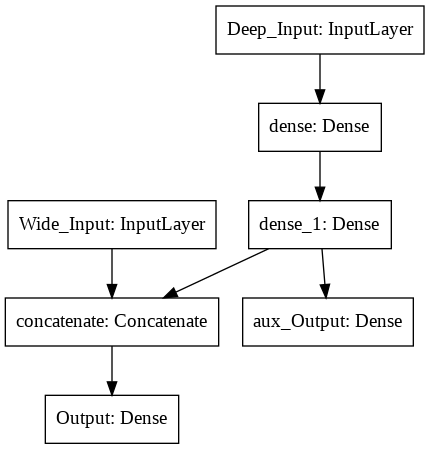

In [ ]:
# define inputs
input_a = Input(shape=[1], name="Wide_Input")
input_b = Input(shape=[1], name="Deep_Input")

# define deep path
hidden_1 = Dense(30, activation="relu")(input_b)
hidden_2 = Dense(30, activation="relu")(hidden_1)

# define merged path
concat = concatenate([input_a, hidden_2])
output = Dense(1, name="Output")(concat)

# define another output for the deep path
aux_output = Dense(1,name="aux_Output")(hidden_2)

# build the model
model = Model(inputs=[input_a, input_b], outputs=[output, aux_output])

# visualize the architecture
plot_model(model)

Implement as a Class

Alternatively, you can also implement this same model as a class. 
- For that, you define a class that inherits from the [Model](https://keras.io/api/models/model/) class.
- Inheriting from the existing `Model` class lets you use the Model methods such as `compile()`, `fit()`, `evaluate()`. 

When inheriting from `Model`, you will want to define at least two functions:
- `__init__()`: you will initialize the instance attributes.
- `call()`: you will build the network and return the output layers.

If you compare the two methods, the structure is very similar, except when using the class, you'll define all the layers in one function, `init`, and connect the layers together in another function, `call`.

In [ ]:
# inherit from the Model base class
class WideAndDeepModel(Model):
    def __init__(self, units=30, activation='relu', **kwargs):

      #当我们在写程序时，不确定将来要往函数中传入多少个参数，即可使用可变参数（即不定长参数），用*args,**kwargs表示。
      # *args称之为Non-keyword Variable Arguments，无关键字参数；
      # **kwargs称之为keyword Variable Arguments，有关键字参数； 如 [input_A = , input_B = ]

        '''initializes the instance attributes'''
        super().__init__(**kwargs)
        self.hidden1 = Dense(units, activation=activation)
        self.hidden2 = Dense(units, activation=activation)
        self.main_output = Dense(1)
        self.aux_output = Dense(1)

    def call(self, inputs):
        '''defines the network architecture'''
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        
        return main_output, aux_output

In [ ]:
# create an instance of the model
model = WideAndDeepModel()

subclassing models !!!

### Ungraded Lab: Implementing ResNet

In this lab, you will continue exploring Model subclassing by building a more complex architecture. 

[Residual Networks](https://arxiv.org/abs/1512.03385) make use of skip connections to make deep models easier to train. 
- There are branches as well as many repeating blocks of layers in this type of network. 
- You can define a model class to help organize this more complex code, and to make it easier to re-use your code when building the model.
- As before, you will inherit from the [Model class](https://keras.io/api/models/model/) so that you can make use of the other built-in methods that Keras provides.

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer

#### resnets_demo

In [ ]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Layer 
from tensorflow.keras.models import Model 


class CNNResidual(Model) :

    def __init__(self, layers, filters, **kwargs): # number of layers and filters
        super(CNNResidual, self).__init__(**kwargs)  

        self.HiddenCNN = [Conv2D(filters, (3,3), activation='relu') for _ in range(layers)] 



    def call(self, inputs) : 
        x = inputs 
        for layer in self.HiddenCNN: 
            x = layer(x) # x will later become as the (x)
        return inputs + x 


class DNNResidual(Model) : 

    def __init__(self, layers, neurons, **kwargs):  # number of layers and neurons
        super(DNNResidual, self).__init__(**kwargs)  

        self.HiddenDNN = [Dense(neurons, activation='relu') for _ in range(layers)]  


    def call(self, inputs) : 
        x = inputs 
        for layer in self.HiddenDNN : 
            x = layer(x) 
        return inputs + x  


class MyResidual(Model) : 

    def __init__(self, **kwargs): 
        super(MyResidual, self).__init__(self) 

        self.hidden1 = Dense(60, activation= 'relu') 
        self.block1 = CNNResidual(3, 64) # 3 layers and each with 64 filters
        self.block2 = DNNResidual(3, 64) # 3 layers and each with 64 neurons
        self.out = Dense(1) 


    def call(self, inputs) :  

        x = self.hidden1(inputs) 
        x = self.block1(x) 
        for _ in range(1, 4): 
            x = self.block2(x) 

        return self.out(x) 



In [ ]:

#from tensorflow.keras.utils import plot_model
# define inputs
#inputs = Input(shape=[1], name="Input")
#outputs = MyResidual(inputs)

# build the model
#model = MyResidual(inputs)

# visualize the architecture
# plot_model(model)

TypeError: ignored

#### resnet_demo2

As shown in the lectures, you will first implement the Identity Block which contains the skip connections (i.e. the `add()` operation below. This will also inherit the Model class and implement the `__init__()` and `call()` methods.

In [ ]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Layer, Add, BatchNormalization, Activation
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model   

class IdentityBlock(Model) : 
    def __init__(self, filters, kernal_size,  **kwargs) : 
        super(IdentityBlock, self).__init__(**kwargs)  

        self.conv1 = Conv2D(filters, kernal_size, padding='same') 
        self.bn1 = BatchNormalization() 

        self.act = Activation('relu') 

        self.add = Add() 


    def call(self, inputs) : 

        x = self.conv1(inputs) 
        x = self.bn1(x) 
        x = self.act(x)  

        x = self.conv1(x) 
        x = self.bn1(x) 
        x = self.act(x) 


        x = self.add([x, inputs]) 
        x = self.act(x) 

        return x 

#From there, you can build the rest of the ResNet model. 

# You will call your `IdentityBlock` class two times below 
# and that takes care of inserting those blocks of layers into this network.

class ResNet(Model) : 
    
    def __init__(self, num_classes, **kwargs) : 
        super(ResNet, self).__init__(**kwargs)  

        self.conv = Conv2D(64, 7, padding= 'same') 
        self.bn = BatchNormalization() 
        self.act = Activation('relu') 

        self.max_pool = tf.keras.layers.MaxPool2D((3,3)) 

        self.idblock1 = IdentityBlock(64, 3) # filter is (3,3)
        self.idblock2 = IdentityBlock(64, 3) 

        self.glob_pool = tf.keras.layers.GlobalAveragePooling2D() 
        
        self.classifier = Dense(num_classes, activation= 'softmax') 


    def call(self, inputs) : 

        x = self.conv(inputs) 
        x = self.bn(x) 
        x = self.act(x) 

        x = self.max_pool(x) 

        x = self.idblock1(x) 
        x = self.idblock2(x) 

        x = self.glob_pool(x) 

        x = self.classifier(x) 

        return x 


resnet = ResNet(10) 


Training the Model

As mentioned before, inheriting the Model class allows you to make use of the other APIs that Keras provides, such as:
- training
- serialization
- evaluation

You can instantiate a Resnet object and train it as usual like below:

**Note**: If you have issues with training in the Coursera lab environment, you can also run this in Colab using the "open in colab" badge link.

In [ ]:
# utility function to normalize the images and return (image, label) pairs.
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255., features['label']

# create a ResNet instance with 10 output units for MNIST, 10 classes
resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# load and preprocess the dataset
dataset = tfds.load('mnist', split=tfds.Split.TRAIN, data_dir='./data')
dataset = dataset.map(preprocess).batch(32)

# train the model.
resnet.fit(dataset, epochs=1)

## Callback

In [ ]:
Callback
ModelCheckpoint

callbacks = [ModelChenckpoint('saved_model', ...)]
callbacks = [ModelChenckpoint('model.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)]
callbacks = [ModelChenckpoint('weights.{epoch: 02d}-{val.loss:.2f}', verbose = 1)] # file name
#  And as the name of the file is just specified using text, you can actually form at the values within the name, 
# so you could have separate weights saved out pair epoch in separate h5 files. 
# Simply by using the epoch value or other metrics such as the validation lost value you conform at the file name 
# so you can see here the last two digits of the epoch are used, so the file is wait 01 wait 02 and so on.

callbacks = [Earlystopping(patience=3, restore_best_weights = True, monitor = 'val_loss', verbose = 1)] 
# wait 3 epochs to see whether it will be proved and restore the best during

callbacks = [CSVLogger('training.csv')] # save as csv file



### Ungraded Lab: Introduction to Keras callbacks

In Keras, `Callback` is a Python class meant to be subclassed to provide specific functionality, with a set of methods called at various stages of training (including batch/epoch start and ends), testing, and predicting. Callbacks are useful to get a view on internal states and statistics of the model during training. The methods of the callbacks can  be called at different stages of training/evaluating/inference. Keras has available [callbacks](https://keras.io/api/callbacks/) and we'll show how you can use it in the following sections. Please click the **Open in Colab** badge above to complete this exercise in Colab. This will allow you to take advantage of the free GPU runtime (for faster training) and compatibility with all the packages needed in this notebook.

**Model methods that take callbacks**

Users can supply a list of callbacks to the following `tf.keras.Model` methods:
* [`fit()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit), [`fit_generator()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit_generator)
Trains the model for a fixed number of epochs (iterations over a dataset, or data yielded batch-by-batch by a Python generator).
* [`evaluate()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#evaluate), [`evaluate_generator()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#evaluate_generator)
Evaluates the model for given data or data generator. Outputs the loss and metric values from the evaluation.
* [`predict()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#predict), [`predict_generator()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#predict_generator)
Generates output predictions for the input data or data generator.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import io
from PIL import Image

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
%load_ext tensorboard

import os
import matplotlib.pylab as plt
import numpy as np
import math
import datetime
import pandas as pd

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

In [ ]:
# Download and prepare the horses or humans dataset

splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'])

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [ ]:
SIZE = 150 #@param {type:"slider", min:64, max:300, step:1}
IMAGE_SIZE = (SIZE, SIZE)

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label

In [ ]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [ ]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

In [ ]:
def build_model(dense_units, input_shape=IMAGE_SIZE + (3,)):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(dense_units, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax')
  ])
  return model

**[TensorBoard](https://keras.io/api/callbacks/tensorboard/)**

Enable visualizations for TensorBoard.

In [ ]:
!rm -rf logs

model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

model.fit(train_batches, 
          epochs=10, 
          validation_data=validation_batches, 
          callbacks=[tensorboard_callback])
%tensorboard --logdir logs

**[Model Checkpoint](https://keras.io/api/callbacks/model_checkpoint/)**

Callback to save the Keras model or model weights at some frequency.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', verbose=1),
          ])

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=1, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('saved_model', verbose=1)
          ])

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=2, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('model.h5', verbose=1)
          ])

**[Early stopping](https://keras.io/api/callbacks/early_stopping/)**

Stop training when a monitored metric has stopped improving.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=50, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[EarlyStopping(
              patience=3,
              min_delta=0.05,
              baseline=0.8,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1)
          ])

**[CSV Logger](https://keras.io/api/callbacks/csv_logger/)**

Callback that streams epoch results to a CSV file.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
csv_file = 'training.csv'

model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          callbacks=[CSVLogger(csv_file)
          ])

In [ ]:
pd.read_csv(csv_file).head()

[Learning Rate Scheduler](https://keras.io/api/callbacks/learning_rate_scheduler/)

Updates the learning rate during training.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
def step_decay(epoch):
	initial_lr = 0.01
	drop = 0.5
	epochs_drop = 1
	lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lr

model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          callbacks=[LearningRateScheduler(step_decay, verbose=1),
                    TensorBoard(log_dir='./log_dir')])

In [ ]:
%tensorboard --logdir log_dir

[ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/)

Reduce learning rate when a metric has stopped improving.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=50, 
          validation_data=validation_batches, 
          callbacks=[ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.2, verbose=1,
                                       patience=1, min_lr=0.001),
                     TensorBoard(log_dir='./log_dir')])

In [ ]:
%tensorboard --logdir log_dir

### Ungraded Lab: Keras custom callbacks
A custom callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference. Towards the end of this guide, there will be demos of creating a couple of simple callback applications to get you started on your custom callback.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io

from PIL import Image
from IPython.display import Image as IPyImage
import imageio

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

In [ ]:
# Define the Keras model to add callbacks to
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1, activation = 'linear', input_dim = 784))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.1), loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
# Then, load the MNIST data for training and testing from Keras datasets API:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [ ]:
# Now, define a simple custom callback to track the start and end of every batch of data. 
# During those calls, it prints the index of the current batch.

class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_train_batch_begin(self, batch, logs=None):
        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

In [ ]:
# Providing a callback to model methods such as tf.keras.Model.fit() ensures the methods are called at those stages:
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

In [ ]:
# Usage of logs dict
# The logs dict contains the loss value, and all the metrics at the end of a batch or epoch. 
# Example includes the loss and mean absolute error.
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch,logs: 
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))
)

model = get_model()
_ = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=64,
          epochs=3,
          verbose=0,
          callbacks=[callback])

In [ ]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.7):
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs["loss"]
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

        if ratio > self.threshold:
            print("Stopping training...")
            self.model.stop_training = True

model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[DetectOverfittingCallback()])

In [ ]:
# Custom callback to Visualize predictions

# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]: 
            t.set_color('green') 
        else: 
            t.set_color('red')
    plt.grid(None)

GIF_PATH = './animation.gif'

class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs # x values we train off of 
        self.ground_truth = ground_truth # the y value we train off of
        self.images = []  # array
        self.display_freq = display_freq # the number of epoch
        self.n_samples = n_samples

    def on_epoch_end(self, epoch, logs=None):
        # Randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]# x images, y labels
        predictions = np.argmax(self.model.predict(X_test), axis=1)

        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.display_freq)

        # Save the figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))

        # Display the digits every 'display_freq' number of epochs
        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)  # save to GIF_PATH, fps = frame rates


def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])


SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE) 

#### **An overview of callback methods**


##### **Common methods for training/testing/predicting**

For training, testing, and predicting, following methods are provided to be overridden.
###### `on_(train|test|predict)_begin(self, logs=None)`
Called at the beginning of `fit`/`evaluate`/`predict`.
###### `on_(train|test|predict)_end(self, logs=None)`
Called at the end of `fit`/`evaluate`/`predict`.
###### `on_(train|test|predict)_batch_begin(self, batch, logs=None)`
Called right before processing a batch during training/testing/predicting. Within this method, `logs` is a dict with `batch` and `size` available keys, representing the current batch number and the size of the batch.
###### `on_(train|test|predict)_batch_end(self, batch, logs=None)`
Called at the end of training/testing/predicting a batch. Within this method, `logs` is a dict containing the stateful metrics result.

##### **Training specific methods**

In addition, for training, following are provided.
###### `on_epoch_begin(self, epoch, logs=None)`
Called at the beginning of an epoch during training.
###### `on_epoch_end(self, epoch, logs=None)`
Called at the end of an epoch during training.